<a href="https://colab.research.google.com/github/emolter/ay250-homework/blob/main/hw6_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW6: Machine learning

**Due Wednesday April 6, 8pm**

(AY250 2022)

## Galaxy Classification with CNNs

Galaxies appear with different shapes and colors depending on a number of factors, including age, distance, and history of mergers with other galaxies. A crowd-sourced group was [asked to visually classify a set of galaxies from a telescope survey](https://data.galaxyzoo.org/gz_trees/gz_trees.html), resulting in a labelled dataset of 21,785 galaxies across 10 different labels.

You can download it locally:
```bash
curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
```
Or access it on the shared drive on `astro.datahub.berkeley.edu` at `shared/HW_6/galaxies10.h5`

First, load the data:

In [ ]:
!curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200M  100  200M    0     0  49.7M      0  0:00:04  0:00:04 --:--:-- 49.7M


In [ ]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('galaxies10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (21785, 10)
images shape: (21785, 69, 69, 3)


### Visualize and inspect

In a single, multi-panel figure visualize one randomly chosen galaxy from each of the 10 classes. Be sure to set the random seed so that your figure will be reproducible. 

In [ ]:
print(labels[:10,:])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


sorted index 3196 chosen, has type 0
sorted index 5580 chosen, has type 1
sorted index 14126 chosen, has type 2
sorted index 16907 chosen, has type 3
sorted index 18290 chosen, has type 4
sorted index 18638 chosen, has type 5
sorted index 19074 chosen, has type 6
sorted index 19862 chosen, has type 7
sorted index 20484 chosen, has type 8
sorted index 21477 chosen, has type 9


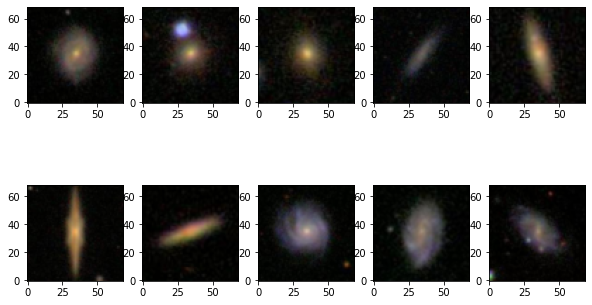

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

rng = np.random.default_rng(404)

_, labels_1d = np.nonzero(labels)
labels_sorted = np.sort(labels_1d)
labels_idx = np.argsort(labels_1d)
images_sorted = images[labels_idx]
unq, unq_idx = np.unique(labels_sorted, return_index = True)
unq_idx = np.append(unq_idx, labels_1d.shape[0])

fig, axes = plt.subplots(2,5, figsize = (10, 6))

for i in range(len(unq)):
    j = rng.integers(unq_idx[i], unq_idx[i+1], size = 1)[0]
    print(f'sorted index {j} chosen, has type {labels_sorted[j]}')
    ax = axes.flatten()[i]
    
    # need these as type int or else clips them all between 0 and 1
    ax.imshow(images_sorted[j].astype(int), origin = 'lower')
    
plt.show()

Show a histogram of the distribution of galaxies across classes. Comment on any differences you notice with this dataset and the MNIST.

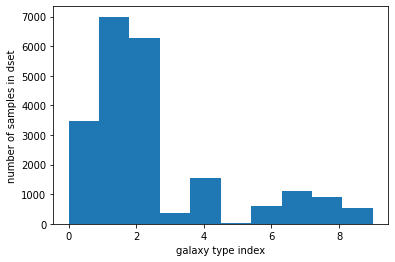

In [ ]:
plt.hist(labels_1d)
plt.xlabel('galaxy type index')
plt.ylabel('number of samples in dset')
plt.show()

Unlike the MNIST dataset, the distribution is very heterogeneous: there are many more galaxies of types 1 and 2 than the other types.  There are almost no galaxies of type 5, for example

### Prepare for training

First, split the dataset into a train, validation, and test set with a fixed random seed. Then, construct a simple (~few layers) CNN that will accommodate the 69x69x3 images and return a classification. Hint: you will need to modify the networks we built in class to handle the 3d inputs (check out `Conv3D` https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D).

In [ ]:
import datetime, os
import warnings

from IPython.external import mathjax

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization, Conv3D, MaxPooling3D
)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
# Print keras version
print("Using tensorflow version:", tensorflow.keras.__version__)

Using tensorflow version: 2.8.0


In [ ]:
# split data here
rng = np.random.default_rng(404)
indices = np.arange(0,images.shape[0])
rng.shuffle(indices)

images_shuffled = images[indices,:,:,:]
labels_shuffled = labels[indices,:]

cut1 = int(images.shape[0]*0.45)
cut2 = int(images.shape[0]*0.9)
training_i = indices[:cut1]
test_i = indices[cut1:cut2]
validation_i = indices[cut2:]

training_set = images[training_i] # 45%
training_labels = labels[training_i]
test_set = images[test_i] # 45%
test_labels = labels[test_i]
validation_set = images[validation_i] # 10%
validation_labels = labels[validation_i]

input_shape = training_set[0].shape  + (1,)
nb_classes = 10

print(f'training set, test set, and validation set shapes: {training_set.shape, test_set.shape, validation_set.shape}')


training set, test set, and validation set shapes: ((9803, 69, 69, 3), (9803, 69, 69, 3), (2179, 69, 69, 3))


In [ ]:
# add with tf.device('/gpu:0'): if on GPU

with tf.device('/gpu:0'):
    model = Sequential()

    model.add(Conv3D(32, (3, 3, 1), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))

    model.add(Conv3D(64, (3, 3, 1), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 1)))

    #model.add(Conv3D(128, (3, 3, 1), input_shape=input_shape))
    #model.add(Activation('relu'))

    model.add(Flatten())

    #model.add(Dense(128, activation='relu'))

    model.add(Dense(32, activation='relu'))


    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 67, 67, 3, 32)     320       
                                                                 
 batch_normalization (BatchN  (None, 67, 67, 3, 32)    128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 67, 67, 3, 32)     0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 33, 33, 3, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 31, 31, 3, 64)     18496     
                                                                 
 activation_1 (Activation)   (None, 31, 31, 3, 64)     0

### Train

Using early stopping and learning rate decay, train the network you built. Use the validation dataset at the end of each epoch for the early stopping. You might decide to do this part on colab for GPU access.

In [ ]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/galaxies_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(x=training_set, 
          y=training_labels, 
          epochs=20,
          batch_size=128,
          validation_data=(validation_set, validation_labels), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/galaxies_nn_2022-04-03T23:13.h5
Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 2.0002 - accuracy: 0.3379
Epoch 1: val_accuracy improved from -inf to 0.33043, saving model to nn_results/galaxies_nn_2022-04-03T23:13.h5
77/77 [==============================] - 28s 232ms/step - loss: 2.0002 - accuracy: 0.3379 - val_loss: 1.7518 - val_accuracy: 0.3304 - lr: 0.0010
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 1.4703 - accuracy: 0.4240
Epoch 2: val_accuracy improved from 0.33043 to 0.39192, saving model to nn_results/galaxies_nn_2022-04-03T23:13.h5
77/77 [==============================] - 17s 222ms/step - loss: 1.4703 - accuracy: 0.4240 - val_loss: 1.4787 - val_accuracy: 0.3919 - lr: 0.0010
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 1.2641 - accuracy: 0.4985
Epoch 3: val_accuracy improved from 0.39192 to 0.46489, saving model to nn_results/galaxies_nn_2022-04-03T23:13.h5
77/77 [=======================

### Evaluation

Use your trained model and apply it to the test set. How well did you do (total accuracy)? Plot a confusion matrix and comment where the network was most confused.

In [ ]:
!ls nn_results

20220403-231309				  galaxies_nn_2022-04-03T23:13.h5
20220403-231833				  training_2022-04-03T23:13.log
ay250_autoencoder_nn_2022-04-03T23:18.h5


Overall accuracy was 0.6739773538712639
tf.Tensor(
[[ 716  294  345   11   30    0    2   64   51   20]
 [  86 2726  331    0    6    0    0    6    3    2]
 [ 160  528 2092    0   13    0    0   13    1    2]
 [   6    3   21   50   66    0   16    0    0    1]
 [  21    9   42   40  585    2   40    0    0    3]
 [   0    0    0    0    5    0    2    0    0    0]
 [   2    0    1   16   75    1  170    0    0    0]
 [ 149   56   45    2    2    0    0  178   57    7]
 [ 195   12   21    1    1    0    1   81   70   16]
 [ 120    9   34    6   16    2    5    9    9   20]], shape=(10, 10), dtype=int32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


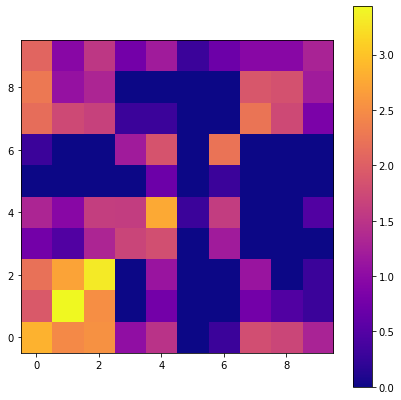

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.math import confusion_matrix

#load the model from disk
latest_log_file = !ls -t1 nn_results/training* | head -1
latest_model_file = !ls -t1 nn_results/galaxies_*.h5 | head -1
hist_df = pd.read_csv(latest_log_file[0])
model = load_model(latest_model_file[0])

# predict
predicted_labels = model.predict(test_set)
#hist_df
predicted_labels_1d = np.argmax(predicted_labels, axis = 1)
test_labels_1d = np.argmax(test_labels, axis = 1)
print(f'Overall accuracy was {np.sum(predicted_labels_1d == test_labels_1d)/predicted_labels_1d.size}')

# plot - use log so can see better
confusion = confusion_matrix(test_labels.argmax(axis=1), predicted_labels.argmax(axis=1))
#print(confusion)
logconfusion = np.log10(confusion)
logconfusion[logconfusion<0] = 0

fig, ax = plt.subplots(1,1,figsize = (7,7))
im = ax.imshow(logconfusion, origin = 'lower', cmap = 'plasma')
fig.colorbar(im)
plt.show()

The overall accuracy for the test set was 67%, which was pretty close to the best epoch for the validation set (68%). The confusion matrix (note log space here) shows that the model is doing a decent job on labels 1,2,4,6,7 (more than half correct guesses); less well on 0,3,8 (correct guess is most likely option, but more likely than not to guess incorrectly), and horribly on 5,9 (correct guess isn't even the most likely option). This is roughly, although not entirely, in line with the number of examples of each galaxy type we have in the histogram above. It's unsurprising that label 5 looks so bad because we have few examples in the dataset, but it's a bit surprising that index 0 is harder to distinguish than 4 despite many more examples.

### Improve - data augmentation

Now that you have a baseline accuracy, you can work to try to improve the results. Without changing your network architecture, implement a data augmentation strategy, retrain, and then reevaluate. How much improvement did you see?

I think for galaxies, rotating and zooming are both totally valid. So I'm basically going to copy what was done for the fashion dataset.  I would not be confident rescaling brightness, especially for these tri-color images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=360.,
                     rescale=None,
                     shear_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)

seed = 42
batch_size = 256

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

image_generator = image_datagen.flow(
    training_set,  training_labels,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/galaxies_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(image_generator,
          epochs=20,
          validation_data=(validation_set, validation_labels), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/galaxies_nn_2022-04-04T00:51.h5
Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 1.1091 - accuracy: 0.6101
Epoch 1: val_accuracy improved from -inf to 0.53924, saving model to nn_results/galaxies_nn_2022-04-04T00:51.h5
39/39 [==============================] - 22s 560ms/step - loss: 1.1091 - accuracy: 0.6101 - val_loss: 1.4359 - val_accuracy: 0.5392 - lr: 7.5000e-04
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 0.9568 - accuracy: 0.6418
Epoch 2: val_accuracy improved from 0.53924 to 0.58100, saving model to nn_results/galaxies_nn_2022-04-04T00:51.h5
39/39 [==============================] - 22s 553ms/step - loss: 0.9568 - accuracy: 0.6418 - val_loss: 1.1690 - val_accuracy: 0.5810 - lr: 7.5000e-04
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.9172 - accuracy: 0.6552
Epoch 3: val_accuracy improved from 0.58100 to 0.65122, saving model to nn_results/galaxies_nn_2022-04-04T00:51.h5
39/39 [===============

In [ ]:
!ls nn_results

20220403-231309				  galaxies_nn_2022-04-03T23:13.h5
20220403-231833				  training_2022-04-03T23:13.log
ay250_autoencoder_nn_2022-04-03T23:18.h5


Overall accuracy was 0.7027440579414465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


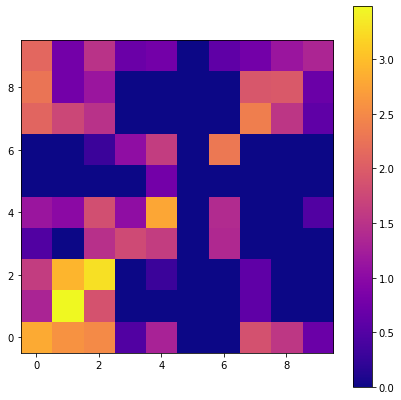

In [ ]:
# predict
predicted_labels = model.predict(test_set)
#hist_df
predicted_labels_1d = np.argmax(predicted_labels, axis = 1)
test_labels_1d = np.argmax(test_labels, axis = 1)
print(f'Overall accuracy was {np.sum(predicted_labels_1d == test_labels_1d)/predicted_labels_1d.size}')

# plot - use log so can see better
confusion = confusion_matrix(test_labels.argmax(axis=1), predicted_labels.argmax(axis=1))
#print(confusion)
logconfusion = np.log10(confusion)
logconfusion[logconfusion<0] = 0

fig, ax = plt.subplots(1,1,figsize = (7,7))
im = ax.imshow(logconfusion, origin = 'lower', cmap = 'plasma')
fig.colorbar(im)
plt.show()

The overall accuracy was 70% this time, a 3% improvement.  Not great, not completely useless

### Improve - network

Change/embellish your original network to try to improve the results (try adding layers, changing the initialization of the kernel weights, changing the activation, adding dropout). You can use an automl trainer if you'd like or try different approaches by hand. Retrain and then reevaluate. Explain what you did but only show us the best model and its evaluation.

I'm going to try using a package I found online by Googling "keras automl trainer", which is called autokeras. It looks like I can simply give it a maximum number of parameters in model and let it figure out the rest. I'll have to look into diagnostics of what it actually did, i.e. what type of network it thinks is best.  See here: https://autokeras.com/tutorial/image_classification/

In [ ]:
import autokeras as ak
from sklearn.metrics import classification_report

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/galaxies_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')
model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model = ak.ImageClassifier(overwrite=True, max_trials=10, seed = 44, max_model_size = 5e5)
model.fit(training_set, training_labels, 
          validation_data=(validation_set,validation_labels), 
          epochs = 20,
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])
#model.final_fit(training_set, training_labels, test_set, test_labels, retrain=True)


score = model.evaluate(test_set, test_labels)
predictions = model.predict(test_set)
report = classification_report(test_labels, predictions)
print(report)
print(score)


Training ... nn_results/galaxies_nn_2022-04-04T19:51.h5
Oversized model: 23718922 parameters -- skipping
Oversized model: 23718922 parameters -- skipping
Oversized model: 23718922 parameters -- skipping
Oversized model: 23718922 parameters -- skipping
Oversized model: 23718922 parameters -- skipping
Oversized model: 23718922 parameters -- skipping


RuntimeError: ignored

This was interesting to try. I limited each trial to 

## Autoencoders

A form of non-parametric representation learning with neutral nets, where the architecture of the network is used to reduce the dimensionality of the data. First, go through (and execute) the following codeblocks and make sure you understand what they are doing to build and use an autoencoder.

As the name suggests, autoencoders uses the data itself to learn the best way to represent it in a compact way--it's a form of semantic compression. This is a family of self- (or un-) supervised modeling.

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png">
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In practice, we take an input X (which may be a 1-d vector, 2-d image, ...) and try to squeeze it down to a smaller number of values in the "bottleneck" layer and then uncompress back to it's original shape and form. The loss function that we construct will be the way in which the network learns on each backprop through the data.

Let's look at a autoencoder which uses convnets to restruct the fashion dataset.

In [ ]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow 
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, \
                                    Activation, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128
bottleneck_size = 64

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape
input_img = Input(shape = (28, 28, 1))

2.8.0
4431872/4422102 [==============================] - 0s 0us/step


Make a simple autoencoder

In [ ]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

Training ... nn_results/ay250_autoencoder_nn_2022-04-03T23:18.h5
Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 0.0348
Epoch 1: val_loss improved from inf to 0.02617, saving model to nn_results/ay250_autoencoder_nn_2022-04-03T23:18.h5
469/469 [==============================] - 9s 16ms/step - loss: 0.0348 - val_loss: 0.0262
Epoch 2/10
468/469 [============================>.] - ETA: 0s - loss: 0.0212
Epoch 2: val_loss improved from 0.02617 to 0.01945, saving model to nn_results/ay250_autoencoder_nn_2022-04-03T23:18.h5
469/469 [==============================] - 7s 15ms/step - loss: 0.0212 - val_loss: 0.0195
Epoch 3/10
468/469 [============================>.] - ETA: 0s - loss: 0.0189
Epoch 3: val_loss improved from 0.01945 to 0.01785, saving model to nn_results/ay250_autoencoder_nn_2022-04-03T23:18.h5
469/469 [==============================] - 7s 15ms/step - loss: 0.0189 - val_loss: 0.0179
Epoch 4/10
469/469 [==============================] - ETA: 0s - loss: 0.0177
E

In [ ]:
from tensorflow.keras.models import load_model
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)

Using nn_results/ay250_autoencoder_nn_2022-04-03T23:18.h5


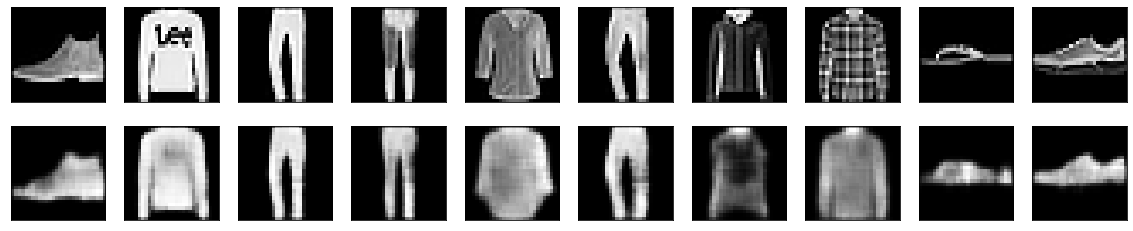

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Classify using Random Forest

Using the autoencoder model above, create a random forest model to predict the classes of the images using the 64-parameter bottleneck layer. What accuracy do you get? How does it compare with the accuracy we got on the `convnet` model before?

### Bottleneck size variation

Experiment with trying a different sized layer (e.g., size 4, 16, 32) and repeat step a) above. Do you see any trends with bottleneck size?